# A Simple Implementation of Regularized Linear Regression
This notebook goes over a implementation of Regularized Linear Regression in Python. The purpose of this notebook is to mainly break down how the linear regression algorithm/model works both through a bare bones implementation and visualization.

First, let's define the key formulas we will need to implement for our model to function:
### The Hypothesis Function
This function will actually be used to predict our outputs ($y$) value based on a given set of inputs ($x$). In this case, our $h(x)$ is going to be a linear function of $n$ dimensional inputs; $\{x_{1}, ..., x_{n}\}$, along with $\{\theta_{0}, ..., \theta_{n}\}$ trainable parameters:

$h_{\theta}(x)  =  \theta_{0} + \theta_{1} * x_{1} + ... + \theta_{n} * x_{n}  =  \theta_{0} + \sum_{i=1}^{n} \theta_{i}x_{i}$

### The Cost Function
This function will be used to assess how well our model can predict the output based on the input $x$ for each labelled data point $\{x, y\}$. We will be using the mean squared error to calculate the cost of each prediction. The $m$ value is the number of training points. Both $x^{(i)}$ and $\theta$ are vectors of size $n\times1$. The second term is the regularization term. When the cost function is being optimized, it will aide in stopping the model from overfitting the training parameters onto the training set. $\lambda$ will control how much weight we want to give the regularization term, this means if $\lambda$ is set too large, the model might have a high bias and perform poorly. Note, $\theta_{0}$ is not regularized.

$J(\theta)  =  \frac{1}{2m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^{2} + \frac{\lambda}{2m}\sum_{j=1}^{n} \theta_{j}^{2}$

### The Gradient Calculation Function
The optimization of the cost function will be done with gradient descent. For this, the gradients of all the trainable parameters must be calculated, that is, the partial derivitives of $\{\frac{\partial J(\theta)}{\partial \theta_{0}}, ..., \frac{\partial J(\theta)}{\partial \theta_{n}}\}$. After calculating the partiel derivatives, the result should be:

$\frac{\partial J(\theta)}{\partial \theta_{0}}  =  \frac{1}{m}  \sum_{i=1}^{m} {(h_{\theta}(x^{(i)}) - y^{(i)})}$

$\frac{\partial J(\theta)}{\partial \theta_{j}}  =  \frac{1}{m}  \sum_{i=1}^{m} {(h_{\theta}(x^{(i)}) - y^{(i)}) x_{j} ^{i}  +  \frac{\lambda}{m} \theta_{j}}   \hspace{10mm} \text{for} \hspace{3mm}j = 1, ..., n$

With these calulations, the gradient descent algorithm can be used to optimize the cost function and train the model. Here is a vectorized implementation of Regularized Linear Regression. The training set is decoupled from the actual regression trainer to make it easier to switch between batch, mini-batch, and stochastic gradient descent. Input data X is an m by n matrix and input label y is a m by 1 vector.

In [1]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, n=1, reg_lambda=0.01, learning_rate=0.001):
        self.n = n
        self.theta = np.zeros((n + 1, 1))
        self.grad = np.zeros((n + 1, 1))
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        
    def train(self, X, y, iterations=None):
        
        # get number of training examples and insert m by 1 bias vector
        m = X.shape[0]
        X = np.insert(X, [0], np.ones((m, 1)), axis=1)
        
        cost_hist = np.zeros(iterations)
        
        for i in range(iterations):
            
            # run batch gradient descent step and calculate cost of updated theta
            self._gradient_descent_batch_step(X, y)
            cost_hist[i] = self._cost_func(X, y)
            
        return cost_hist
            
    def _gradient_descent_batch_step(self, X, y):

        # compute gradients
        self.grad = self._compute_gradients(X, y)
        
        # update theta
        self.theta = self.theta - self.learning_rate * self.grad
        
    def _hypothesis_func(self, X, theta=None):
        if theta is None:
            theta = self.theta
            
        # hypothesis function for prediction
        return np.matmul(X, theta)
    
    def _cost_func(self, X, y, theta=None):
        if theta is None:
            theta = self.theta
            
        # mean squared error cost
        m = X.shape[0]
        return 1/(2 * m) * (np.sum(np.power(np.subtract(self._hypothesis_func(X, theta), y), 2))  +  self.reg_lambda * np.sum(np.power(theta[1:], 2)))
        
    def _compute_gradients(self, X, y):
        m = X.shape[0]
        grad = np.zeros((self.n + 1, 1))
        
        # calculate gradients of theta (calculated grad of theta_0 again to remove the regularization calculation from the vectoried cal.)
        grad = (1/m) * np.transpose(np.matmul(np.transpose(np.sum(np.subtract(self._hypothesis_func(X), y), axis=1, keepdims=True)), X)) + (self.reg_lambda/m) * self.theta 
        grad[0] = (1/m) * np.sum(np.subtract(self._hypothesis_func(X), y))
        
        return grad

### Gradient Checking
Now that gradient descent has been implementated, there needs to be some way to check that the gradient calculations are in fact accurate and there is no logic error present. To do this, gradient checking can be implemented. Gradient checking follows the basic principles of computing tangents of functions both through limits and derivatives and then comparing the two outputs to make sure they are consistent with one another.

Here is a simple example with a polynomial function ($n=1$). 

Polynomial function

$f(x) = x^2$

Tangent (derivative) Calculation througn limits ($h$ being a small value; $h < 0.01$ )

$f'(x) = \frac{f(x + h) - f(x - h)}{2 * h}$

Tangent (derivative) Calculation througn derivative

$f'(x) = 2x$

Now, sample random values of $x$, choose a small $h$ value, and compare the derivative outputs given by the two methods to confirm that both methods are working correctly. You should get similiar values from both methods.

This concept can be applied to the cost function and gradients (derivatives of the cost function) of the linear regression model. The only slight change is that  the cost function contains more than one parameter; $\{\theta_{0}, ..., \theta_{n}\}$. To overcome this, change only one parameter at a time. $h$ will now be a (n + 1) by 1 vector of zeros, with only one element at a time having a slight deviation. Then, cycle through each element of $\{\theta_{0}, ..., \theta_{n}\}$ to calculate every gradient using the limit method. Below is a modified Regularized Linear Regression with gradient checking.

In [2]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, n=1, reg_lambda=0.01, learning_rate=0.001):
        self.n = n
        self.theta = np.zeros((n + 1, 1))
        self.grad = np.zeros((n + 1, 1))
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        
    def train(self, X, y, iterations=None):
        
        # get number of training examples and insert m by 1 bias vector
        m = X.shape[0]
        X = np.insert(X, [0], np.ones((m, 1)), axis=1)
        
        cost_hist = np.zeros(iterations)
        
        for i in range(iterations):
            
            # run batch gradient descent step and calculate cost of updated theta
            self._gradient_descent_batch_step(X, y)
            cost_hist[i] = self._cost_func(X, y)
            
        return cost_hist
    
    def check_gradients(self, sample_size=10, epsilon=1e-3):
        
        # generate random samples
        X_samples = np.random.rand(sample_size, self.n)
        X_samples = np.insert(X_samples, [0], np.ones((X_samples.shape[0], 1)), axis=1)
        y_samples = np.random.rand(sample_size, 1)
        
        #calculate gradients manually through limits and through the gradient equations
        num_grad = self._compute_numerical_gradients(X_samples, y_samples, epsilon)
        grad = self._compute_gradients(X_samples, y_samples)
        
        # calculate average error between the two gradients
        average_error =  np.abs(num_grad - grad).mean()
        
        # return calculated gradients and the average error
        return np.insert(grad, [0], num_grad, axis=1), average_error
            
    def _gradient_descent_batch_step(self, X, y):

        # compute gradients
        self.grad = self._compute_gradients(X, y)

        # update theta
        self.theta = self.theta - self.learning_rate * self.grad
        
    def _hypothesis_func(self, X, theta=None):
        if theta is None:
            theta = self.theta
            
        # hypothesis function for prediction
        return np.matmul(X, theta)
    
    def _cost_func(self, X, y, theta=None):
        if theta is None:
            theta = self.theta
            
        # mean squared error cost
        m = X.shape[0]
        return 1/(2 * m) * (np.sum(np.power(np.subtract(self._hypothesis_func(X, theta), y), 2))  +  self.reg_lambda * np.sum(np.power(theta[1:], 2)))
        
    def _compute_gradients(self, X, y):
        m = X.shape[0]
        grad = np.zeros((self.n + 1, 1))
        
        # calculate gradients of theta (calculated grad of theta_0 again to remove the regularization calculation from the vectoried cal.)
        grad = (1/m) * np.transpose(np.matmul(np.transpose(np.sum(np.subtract(self._hypothesis_func(X), y), axis=1, keepdims=True)), X)) + (self.reg_lambda/m) * self.theta 
        grad[0] = (1/m) * np.sum(np.subtract(self._hypothesis_func(X), y))
        
        return grad
    
    def _compute_numerical_gradients(self, X, y, epsilon):
        
        # declare gradient vector and perturbation vec; this vec contains slight deviations for one theta param at a time
        num_grad = np.zeros((self.n + 1, 1))
        perturbation_vec = np.zeros((self.n + 1, 1))
        
        # calculate numerical gradients using cost func
        for i,_ in enumerate(self.theta):
            perturbation_vec[i] = epsilon
            cost_1 = self._cost_func(X, y, np.add(self.theta, perturbation_vec))
            cost_2 = self._cost_func(X, y, np.subtract(self.theta, perturbation_vec))
            num_grad[i] = (cost_1 - cost_2) / (2 * epsilon)
            perturbation_vec[i] = 0
            
        return num_grad

Below is sample run with 50 random examples, each with 5 features. Notice how when even the y value is generated randomly, the cost goes down everytime, this is because our cost function is convex, meaning there is a global minimum for it to converage to. This sample run does not really give any meaningful insight into the functionality of linear regression, so I will demenstrate this algorithm on a real dataset next.

In [3]:
n = 5
m = 50
X = np.random.rand(m, n)
y = np.random.rand(m, 1)
RLR = RegularizedLinearRegression(n=n)

Before training, let's test that our gradients are functioning correctly using gradient checking with a sample size of 15.

In [4]:
_, average_error = RLR.check_gradients(15)
print(average_error)

3.640606334916659e-15


Running it a few times tell me that linear regresssion is functioning correctly as the average error is pretty small; $< 10^{-13}$. Let's train the model now.

In [5]:
iterations = 300
cost_hist = RLR.train(X, y, iterations=iterations)

Let's plot our cost history next to see that the model was properly trained and is converging to some minimum. If the learning is too large, it might diverge, making the model useless for prediction. A downward sloping curve should be seen, since this was trained on random distributions with no real relations between the output and input, there will be no noticable drop in the beginning iterations.

Text(0.5, 1.0, 'Training Loss')

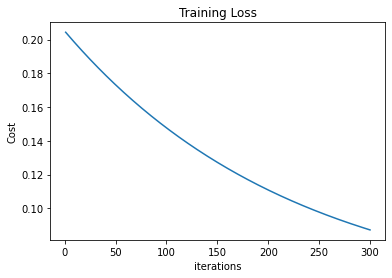

In [6]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, iterations + 1), cost_hist)
plt.xlabel("iterations")
plt.ylabel("Cost")
plt.title("Training Loss")

Next, let's try out linear regression with an actual dataset that has some correlation with the input and output. I am going to use the california housing dataset provided by sklearn. I am also going to use pandas just to load the data and get a feel for how it looks and what it is made up of.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
cali_housing = fetch_california_housing(as_frame=True)

In [9]:
print(cali_housing.data.shape)
cali_housing.frame.head(n=10)

(20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


As seen above, there are 20640 samples present in total and it looks like we have 9 real value descriptions for each sample. It should also be noted that each sample contains data average over a city block. A normal business insight we could gleem from this data is can I predict the value of a house in california based on the features of the block it is located on? Well, let's see. I will first seperate the data into training, cross validation, and test sets so there is a way to measure the performance of a model. The target output value to predict will be the Median House Value. Let's fetch input and output as numpy arrays first.

In [10]:
cali_housing_X, cali_housing_y = fetch_california_housing(return_X_y=True)

In [11]:
print("X Input Vector Shape:  {}".format(cali_housing_X.shape))
print("y Output Vector Shape: {}".format(cali_housing_y.shape))

X Input Vector Shape:  (20640, 8)
y Output Vector Shape: (20640,)


Notice how the y output vector does not explicity state the second parameter of its shape. This is a rank 1 numpy array and it can lead to weird results during matrix calculations. Let's reshape that into a 20640 by 1 vector.

In [12]:
cali_housing_y = np.reshape(cali_housing_y, (20640, 1))
print("y Output Vector Shape: {}".format(cali_housing_y.shape))

y Output Vector Shape: (20640, 1)


In [13]:
# let's shuffle our data first to have a uniform spread among all three subsets
perm = np.random.permutation(cali_housing_X.shape[0])

X_shuffled = cali_housing_X[perm]
y_shuffled = cali_housing_y[perm]

In [14]:
total_size = cali_housing_X.shape[0]
train_ind = int(total_size * 0.7)
val_ind = train_ind + int(total_size * 0.1)

X_train, y_train = X_shuffled[0:train_ind], y_shuffled[0:train_ind] 
X_val, y_val = X_shuffled[train_ind:val_ind], y_shuffled[train_ind:val_ind]
X_test, y_test = X_shuffled[val_ind:], y_shuffled[val_ind:]

In [15]:
print("Training set size:   X = {}, y = {}".format(X_train.shape, y_train.shape))
print("Validation set size: X = {}, y = {}".format(X_val.shape, y_val.shape))
print("Testing set size:    X = {}, y = {}".format(X_test.shape, y_test.shape))

Training set size:   X = (14447, 8), y = (14447, 1)
Validation set size: X = (2064, 8), y = (2064, 1)
Testing set size:    X = (4129, 8), y = (4129, 1)


Linear Regression has to also be updated to track both the training and validation loss over each iteration. Here is the updated code below.

In [16]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, n=1, reg_lambda=0.01, learning_rate=0.001):
        self.n = n
        self.theta = np.zeros((n + 1, 1))
        self.grad = np.zeros((n + 1, 1))
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        
    def train(self, X, y, iterations, X_val=None, y_val=None):
        
        # get number of training examples and insert m by 1 bias vector
        m = X.shape[0]
        X = np.insert(X, [0], np.ones((m, 1)), axis=1)
        
        training_cost_hist = np.zeros(iterations)
        
        if X_val is not None and y_val is not None:
            validation_cost_hist = np.zeros(iterations)
            X_val = np.insert(X_val, [0], np.ones((X_val.shape[0], 1)), axis=1)
            val = True
        else:
            val=False
        
        for i in range(iterations):
            
            # run batch gradient descent step and calculate cost of updated theta
            self._gradient_descent_batch_step(X, y)
            training_cost_hist[i] = self._cost_func(X, y)
            
            if val is not None:
                validation_cost_hist[i] = self._cost_func(X_val, y_val)
            
        if val is not None:
            return training_cost_hist, validation_cost_hist
        return training_cost_hist
    
    def test(self, X_test, y_test):
        X_test = np.insert(X_test, [0], np.ones((X_test.shape[0], 1)), axis=1)
        return self._cost_func(X_test, y_test)
    
    def predict(self, X):
        X = np.insert(X, [0], np.ones((X.shape[0], 1)), axis=1)
        return self._hypothesis_func(X)
    
    def check_gradients(self, sample_size=10, epsilon=1e-3):
        
        # generate random samples
        X_samples = np.random.rand(sample_size, self.n)
        X_samples = np.insert(X_samples, [0], np.ones((X_samples.shape[0], 1)), axis=1)
        y_samples = np.random.rand(sample_size, 1)
        
        #calculate gradients manually through limits and through the gradient equations
        num_grad = self._compute_numerical_gradients(X_samples, y_samples, epsilon)
        grad = self._compute_gradients(X_samples, y_samples)
        
        # calculate average error between the two gradients
        average_error =  np.abs(num_grad - grad).mean()
        
        # return calculated gradients and the average error
        return np.insert(grad, [0], num_grad, axis=1), average_error
            
    def _gradient_descent_batch_step(self, X, y):

        # compute gradients
        self.grad = self._compute_gradients(X, y)
        
        # update theta
        self.theta = self.theta - self.learning_rate * self.grad
        
    def _hypothesis_func(self, X, theta=None):
        if theta is None:
            theta = self.theta
            
        # hypothesis function for prediction
        return np.matmul(X, theta)
    
    def _cost_func(self, X, y, theta=None):
        if theta is None:
            theta = self.theta
            
        # mean squared error cost
        m = X.shape[0]
        return 1/(2 * m) * (np.sum(np.power(np.subtract(self._hypothesis_func(X, theta), y), 2))  +  self.reg_lambda * np.sum(np.power(theta[1:], 2)))
        
    def _compute_gradients(self, X, y):
        m = X.shape[0]
        grad = np.zeros((self.n + 1, 1))
        
        # calculate gradients of theta (calculated grad of theta_0 again to remove the regularization calculation from the vectoried cal.)
        grad = (1/m) * np.transpose(np.matmul(np.transpose(np.sum(np.subtract(self._hypothesis_func(X), y), axis=1, keepdims=True)), X)) + (self.reg_lambda/m) * self.theta 
        grad[0] = (1/m) * np.sum(np.subtract(self._hypothesis_func(X), y))
        return grad
    
    def _compute_numerical_gradients(self, X, y, epsilon):
        
        # declare gradient vector and perturbation vec; this vec contains slight deviations for one theta param at a time
        num_grad = np.zeros((self.n + 1, 1))
        perturbation_vec = np.zeros((self.n + 1, 1))
        
        # calculate numerical gradients using cost func
        for i,_ in enumerate(self.theta):
            perturbation_vec[i] = epsilon
            cost_1 = self._cost_func(X, y, np.add(self.theta, perturbation_vec))
            cost_2 = self._cost_func(X, y, np.subtract(self.theta, perturbation_vec))
            num_grad[i] = (cost_1 - cost_2) / (2 * epsilon)
            perturbation_vec[i] = 0
            
        return num_grad

For the first model being trained, I am not going to normalize the features. This means that I am not going to make sure all the features are in the same range so the model might give preference to training parameters assciated with larger feature values since opitmizing them might give a much better cost. I had to severely reduce the learning rate to keep the gradients from diverging due to this.

In [24]:
n = X_train.shape[1]
iterations = 100000
cali_housing_price_predictor = RegularizedLinearRegression(n=n, learning_rate=1e-7)

Text(0.5, 1.0, 'Loss')

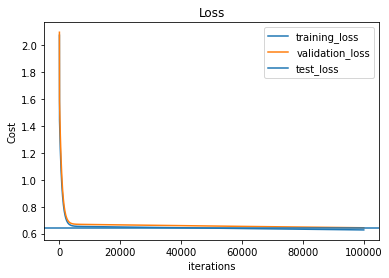

In [25]:
train_cost_hist, val_cost_hist = cali_housing_price_predictor.train(X_train, y_train, iterations, X_val, y_val)
test_loss = cali_housing_price_predictor.test(X_test,y_test)
import matplotlib.pyplot as plt

plt.plot(np.arange(1, iterations + 1), train_cost_hist, label="training_loss")
plt.plot(np.arange(1, iterations + 1), val_cost_hist, label="validation_loss")
plt.axhline(y=test_loss, label="test_loss")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Cost")
plt.title("Loss")


Above is a sample training loop with 100000 iterations. I've tried it with iterations={200, 500, 1000, 10000, 100000} and reshuffled the data a couple of times along with varying the hyperparameters. Each time, the test error is actually relatively low on the graph. This might be due to the fact that train, test, and val sets are very similiar, because this is pretty odd to see. Anyways, the optimial low error is around 0.64 which is not that great considering the y range is (0 - 5). All these target house values are also in $10^{5}$ dollars with a lot of them being $< 10^{4}$, meaning our squared means error is pretty high realistically. There might also be problems with the hand implementation of Linear Regression; I was not taking things such as numerical computation into account when implementing it (defining proper data types and so forth). This is mainly a demo, so I will not be delving into that here though. I will normalize the features and retrain the model to see how it performs next.